<a href="https://colab.research.google.com/github/jonnythebard/tf2_workbook/blob/master/GAN_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# imports
try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from skimage.io import imread

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
2.1.0-rc1


In [0]:
# Load in the data
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# map inputs to (-1, +1) for better training
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1

In [0]:
# flatten the data
N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

In [0]:
# dimensionality of the latent space
latent_dim = 100

In [0]:
# get the generator model

def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(D, activation="tanh")(x)

  model = Model(i, x)
  return model

In [0]:
# get discriminator model

def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation="sigmoid")(x)

  model = Model(i, x)
  return model

In [0]:
# build the discriminator and freeze the weights
discriminator = build_discriminator(D)
discriminator.trainable = False

# build the generator
generator = build_generator(latent_dim)

# create an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))

# pass noise through generator to get an image
img = generator(z)

# the true output is fake, but label them real
fake_pred = discriminator(img)

# build and compile combined model for GAN
combined_model = Model(z, fake_pred)
combined_model.compile(loss="binary_crossentropy", optimizer=Adam(0.002, 0.5))

# compile the discriminator making it trainable
discriminator.trainable = True
discriminator.compile(loss="binary_crossentropy", optimizer=Adam(0.002, 0.5), metrics=["accuracy"])

In [0]:
# train the GAN

# hyperparams
batch_size = 32
epochs = 30000
sample_period = 200 # every sample_period steps generate and save data

# create batch labels to use shen calling train on batch
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# store the losses
d_losses = []
g_losses = []

if not os.path.exists("gan_images"):
  os.makedirs("gan_images")

In [0]:
# a function to create a grid of random samples from the generator
# and save them to a file

def sample_images(epochs):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)

  # rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i, j].imshow(imgs[idx].reshape(H, W), cmap="gray")
      axs[i, j].axis("off")
      idx += 1
    fig.savefig("gan_images/%d.png" % epochs)
    plt.close()

In [25]:
# main training loop
for epoch in range(epochs):
  # train GAN

  # select a random batch of images
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  real_imgs = x_train[idx]

  # generate fake images
  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)

  # train the discriminator
  # teach discriminator real images with ones
  # and also teach it noise with zeros
  # this will make discriminator figure out what are real images and what are noises
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc = 0.5 * (d_acc_real + d_acc_fake)

  # train the generator
  # discriminator is tought how to distinguish real images and noise
  # pass noise as X and ones as Y to combine model, it will predict noises as zeros if generator is not good enough
  # thus generator is trained to make discriminator to predict noise as ones
  # the more trained, the more generator manages to let discriminator predict noises as ones
  # however, since discriminator gets better in predicting noises. (and this will let generator to make better fakes)
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)

  # do it again!
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)

  # do it again!
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)
  

  # save the losses
  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if epoch % 100 == 0:
    print(f"epoch: {epoch}/{epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")

  if epoch % sample_period == 0:
    sample_images(epoch)


epoch: 0/30000, d_loss: 0.94, d_acc: 0.09, g_loss: 0.68
epoch: 100/30000, d_loss: 0.66, d_acc: 0.28, g_loss: 0.81
epoch: 200/30000, d_loss: 0.75, d_acc: 0.38, g_loss: 0.80
epoch: 300/30000, d_loss: 0.71, d_acc: 0.47, g_loss: 0.78
epoch: 400/30000, d_loss: 0.67, d_acc: 0.56, g_loss: 0.83
epoch: 500/30000, d_loss: 0.69, d_acc: 0.52, g_loss: 0.78
epoch: 600/30000, d_loss: 0.69, d_acc: 0.58, g_loss: 0.81
epoch: 700/30000, d_loss: 0.65, d_acc: 0.69, g_loss: 0.75
epoch: 800/30000, d_loss: 0.68, d_acc: 0.61, g_loss: 0.76
epoch: 900/30000, d_loss: 0.69, d_acc: 0.50, g_loss: 0.76
epoch: 1000/30000, d_loss: 0.71, d_acc: 0.36, g_loss: 0.74
epoch: 1100/30000, d_loss: 0.74, d_acc: 0.36, g_loss: 0.77
epoch: 1200/30000, d_loss: 0.71, d_acc: 0.36, g_loss: 0.73
epoch: 1300/30000, d_loss: 0.74, d_acc: 0.33, g_loss: 0.72
epoch: 1400/30000, d_loss: 0.71, d_acc: 0.45, g_loss: 0.74
epoch: 1500/30000, d_loss: 0.71, d_acc: 0.38, g_loss: 0.75
epoch: 1600/30000, d_loss: 0.70, d_acc: 0.47, g_loss: 0.77
epoch: 17

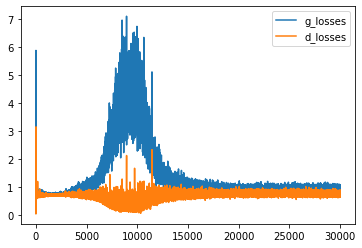

In [26]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

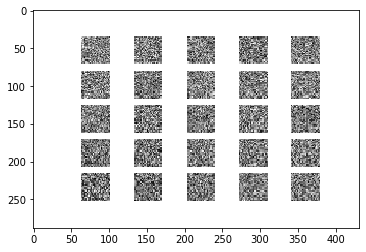

In [27]:
a = imread('gan_images/0.png')
plt.imshow(a)

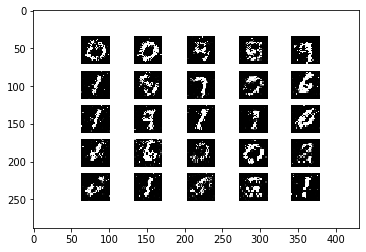

In [28]:
a = imread('gan_images/1000.png')
plt.imshow(a)

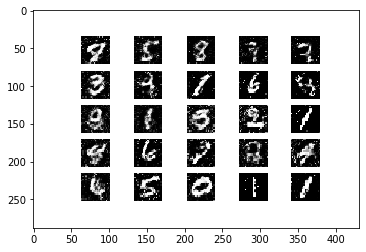

In [29]:
a = imread('gan_images/15000.png')
plt.imshow(a)

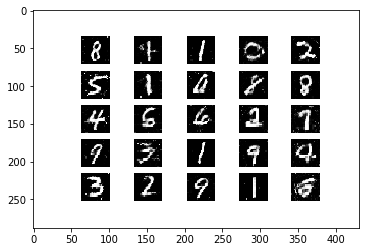

In [30]:
a = imread('gan_images/29800.png')
plt.imshow(a)